**Column Details**
- **PassengerId**: Unique identifier for each passenger, formatted as "Group_Number_Passenger".
- **HomePlanet**: The planet from which the passenger departed (e.g., Earth, Europa, Mars).
- **CryoSleep**: Indicates whether the passenger was in suspended animation during the voyage (True/False).
- **Cabin**: Passenger’s cabin number, structured as "Deck/Number/Side".
- **Destination**: The exoplanet destination of the passenger.
- **Age**: The passenger’s age in years.
- **VIP**: Whether the passenger had VIP status (True/False).
- **RoomService**: Amount spent on in-room service.
- **FoodCourt**: Amount spent at the food court.
- **ShoppingMall**: Amount spent in the shopping mall.
- **Spa**: Amount spent on spa services.
- **VRDeck**: Amount spent on the VR deck.
- **Name**: Full name of the passenger.
- **Transported**: Whether the passenger was transported to another dimension (True/False).


In [1]:
# importing all the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data
df = pd.read_csv(r"/content/spaceship_titanic.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.shape

(8693, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


* We have 7 object columns.
* We also have 7 numerical columns (6f & 1bool)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


Looking at this we can infer:
* We have a quite a few null values.
* Most of the columns are highl deviated meaning we'll have to use scaling methods to scale them.
* Many of the columns appears to be right tailed, let's figure out their distribution in a better way using visualization techniques.

In [6]:
# Detecting null values
df.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


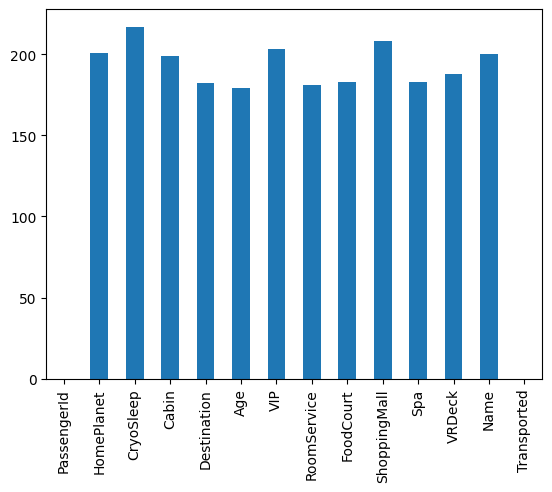

In [7]:
#plotting null values
df.isnull().sum().plot.bar()
plt.show()

* Like we infer earlier we do have a lot of null values in all the columns.
* Now we can either fill the null values using mean for the numerical columns and mode for the categorical columns but that is not a smart way to fill them.
* Rather we can find the relationship between other columns and then figure out a way to fill them smartly instead.

In [11]:
col = df.loc[:, 'RoomService':'VRDeck'].columns   #selcting 5 columns
df.groupby('VIP')[col].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,217.218527,426.336536,173.876298,301.711045,282.718056
True,473.615385,1811.393782,247.726804,760.710660,1234.856410


VIP people tend to spend more than npn-VIPs.

In [12]:
df.groupby('CryoSleep')[col].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,350.146772,713.004316,270.586504,486.09294,475.716165
True,0.000000,0.000000,0.000000,0.00000,0.000000


Passengers in CryoSleep are not allowed outside of their cabins during the whole voyage, hence we can place 0 where ever are in CryoSleep for the above given services.

In [13]:
temp = df['CryoSleep'] == True
df.loc[temp, col] = 0.0

In [14]:
for c in col:
    for val in [True, False]:
        temp = df['VIP'] == val
        k = df.loc[temp, c].astype(float).mean()
        df.loc[temp, c] = df.loc[temp, c].fillna(k)

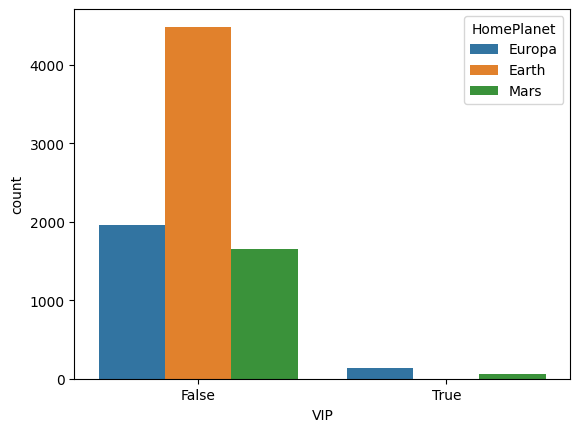

In [15]:
sns.countplot(data=df, x='VIP', hue='HomePlanet')
plt.show()

There is a significant relation between being a non-VIP and coming from Earth and being a VIP and coming from Europa.

In [16]:
col = 'HomePlanet'
temp = df['VIP'] == False
df.loc[temp, col] = df.loc[temp, col].fillna("Earth")

temp = df['VIP'] == True
df.loc[temp, col] = df.loc[temp, col].fillna("Europa")

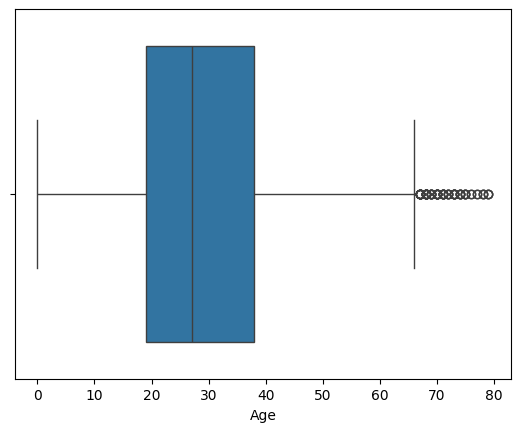

In [17]:
sns.boxplot(df['Age'], orient = 'h')
plt.show()

We will calculate mean of age by excluding outliers and then impute the null values.

In [18]:
temp = df[df['Age']<61]['Age'].mean()
df['Age'] = df['Age'].fillna(temp)

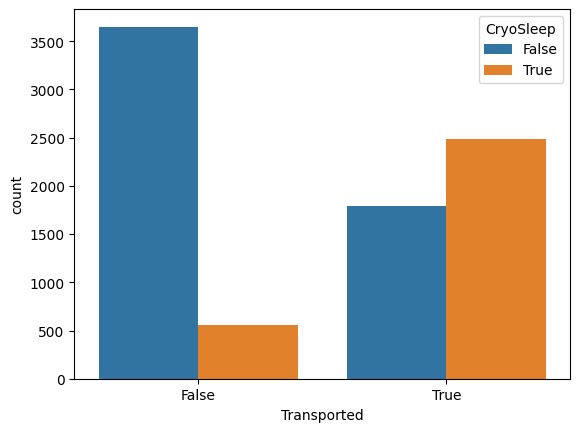

In [20]:
sns.countplot(data=df, x='Transported', hue='CryoSleep')
plt.show()

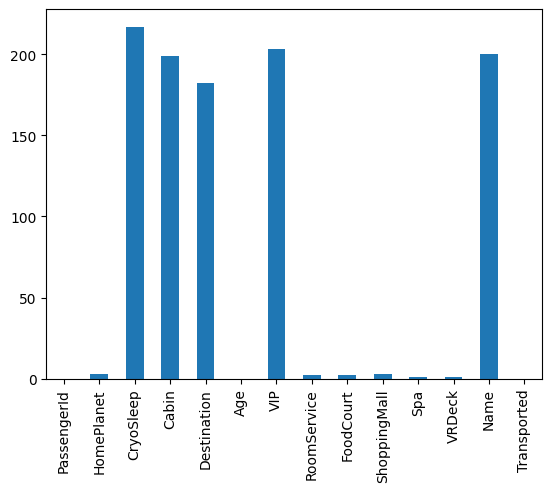

In [22]:
df.isnull().sum().plot.bar()
plt.show()

* We tried to figure out values based on relationship with respect to other columns now let's fill the rest with mean and mode.
* The 'name' colum might be a concern to few people but for training the model we won't be using the name column so even if we fill it with mode value it will not really effect the model training.


In [27]:
for col in df.columns:
    if df[col].isnull().sum() == 0:
        continue

    if df[col].dtype == object or df[col].dtype == bool:
        df[col] = df[col].fillna(df[col].mode()[0])

    else:
        df[col] = df[col].fillna(df[col].mean())
df.isnull().sum().sum()

0

* Finally we got rid of all the null vlaues.

---


Now let's focus on **Feature Engineering**.

In [33]:
df['PassengerId'].head()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


We can see the PassengerId is in the embedded form of (PassengerNo_RoomNo), let's separate them.

In [34]:
new = df['PassengerId'].str.split("_", n=1, expand=True)
df['RoomNo'] = new[0].astype(int)
df['PassengerNo'] = new[1].astype(int)

df.drop(['PassengerId','Name'],axis=1 ,inplace=True)

Now let's fill eac room number with the maximum number of passengers it is holding.

In [35]:
data = df['RoomNo']
for i in range(df.shape[0]):
    temp = data == data[i]
    df['PassengerNo'][i] = (temp).sum()

In [37]:
# RoomNo do not ahve any relevance in getting transorted so we'll remove it

df.drop(['RoomNo'], axis=1, inplace=True)

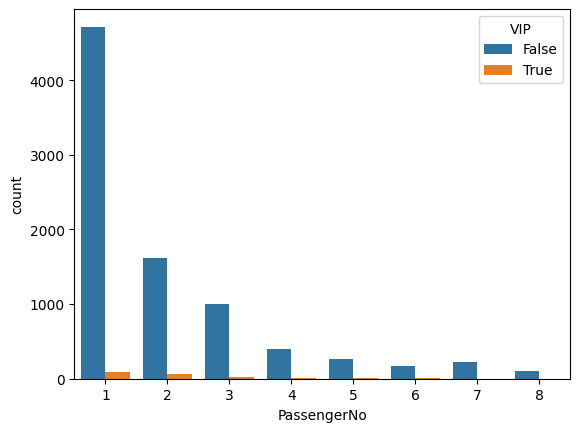

In [38]:
sns.countplot(data = df, x = 'PassengerNo', hue='VIP')
plt.show()

* It is clear that the VIP people hardly share their rooms.

In [40]:
# Let's separate Cabin column
new = df['Cabin'].str.split("/", n=2, expand=True)
df['F1'] = new[0]
df['F2'] = new[1].astype(int)
df['F3'] = new[2]

df.drop(['Cabin'], axis=1, inplace=True)

In [41]:
# Now Let's combine all the expenses into one column
df['LeisureBill'] = df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']


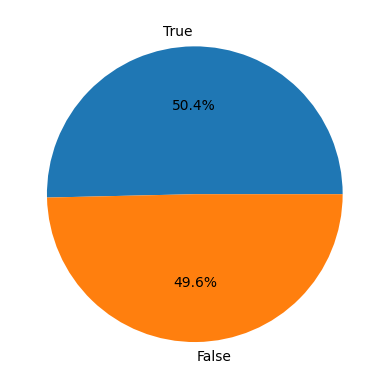

In [42]:
x = df['Transported'].value_counts()
plt.pie(x.values, labels=x.index, autopct="%1.1f%%")
plt.show()

Target variable seems to be balanced, which is good news for model training.

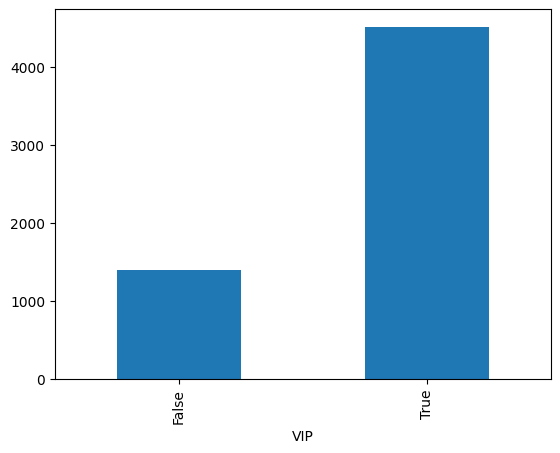

In [43]:
df.groupby('VIP').mean(numeric_only=True)['LeisureBill'].plot.bar()
plt.show()

Spendings for VIP people is more than non-VIP.

In [44]:
for col in df.columns:
    if df[col].dtype == object:     #For categorical columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNo,F1,F2,F3,LeisureBill
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,5,0,1,736.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,2,0,0,1,10383.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,2,0,0,1,5176.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,5,1,1,1091.0


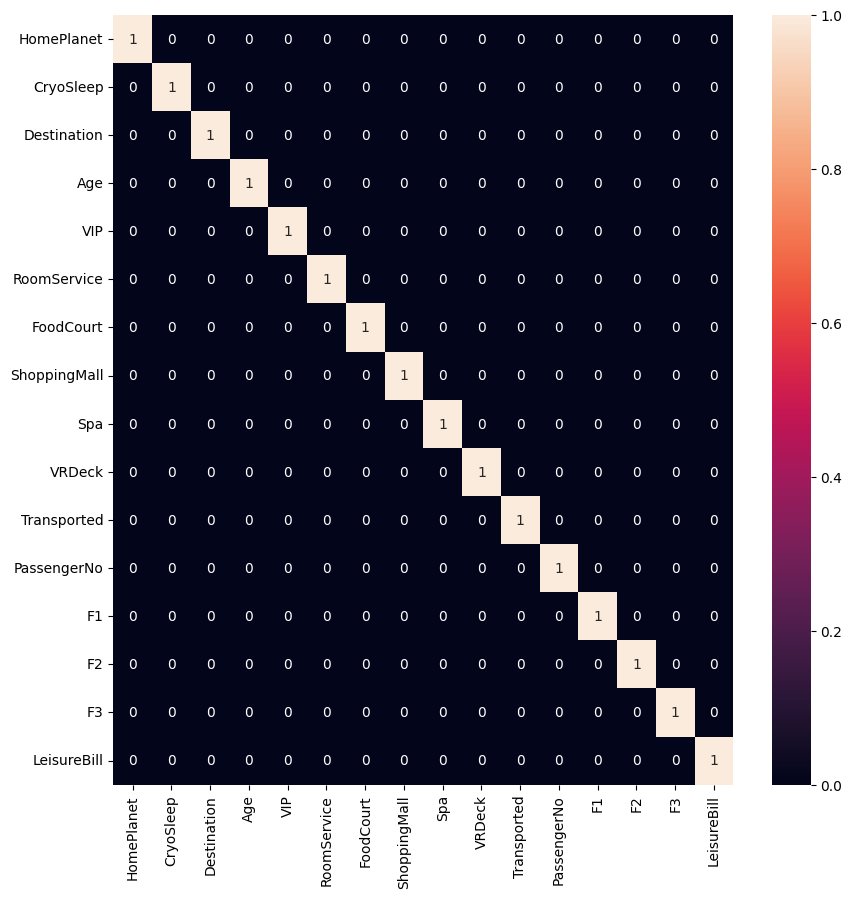

In [47]:
# let's check for correlation
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()>0.8, annot=True, cbar=True)
plt.show()

Looks good for enough for training the model.


---
**Model Training**


In [49]:
# Feature Extraction
x = df.drop(['Transported'], axis=1)
y = df['Transported']

# Splitting the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7823, 15), (870, 15), (7823,), (870,))

In [50]:
# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [56]:
from sklearn.metrics import roc_auc_score

models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(3):
    models[i].fit(x_train, y_train)

    print(models[i].__class__.__name__)

    train_pred = models[i].predict(x_train)
    print("Training Accuracy: ", roc_auc_score(train_pred, y_train))

    test_pred = models[i].predict(x_test)
    print("Testing Accuracy: ", roc_auc_score(test_pred, y_test))
    print()

LogisticRegression
Training Accuracy:  0.7918488192216292
Testing Accuracy:  0.7582250074099166

XGBClassifier
Training Accuracy:  0.9389091119635044
Testing Accuracy:  0.7537738906807083

SVC
Training Accuracy:  0.8138915248262144
Testing Accuracy:  0.7889793263204657



* SVC is performing the best.
* Although our model is an ok model.

---


**Model Evaluation**

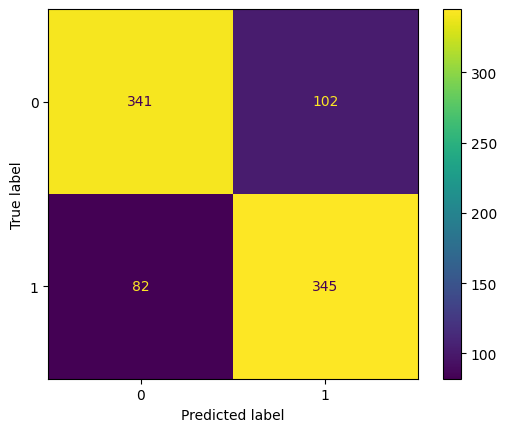

In [57]:
y_pred = models[2].predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [58]:
# let's also pring classification report fo the same
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       443
           1       0.77      0.81      0.79       427

    accuracy                           0.79       870
   macro avg       0.79      0.79      0.79       870
weighted avg       0.79      0.79      0.79       870



Thank you for going through this till the end, feel free to get in touch if you have any doubts... :)